In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd
import cv2
import cv2

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [41]:
data_dir = 'PlantVillage'

# Data Preprocessing

In [42]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [43]:
full_dataset = datasets.ImageFolder(root=data_dir)

train_size = int(0.8 * len(full_dataset))
val_test_size = len(full_dataset) - train_size

val_size = int(0.5 * val_test_size)
test_size = val_test_size - val_size

train_dataset, val_test_dataset = random_split(full_dataset, [train_size, val_test_size])
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 16510, Validation size: 2064, Test size: 2064


In [44]:
# Apply transformations
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val_test']
test_dataset.dataset.transform = data_transforms['val_test']

In [45]:
# DataLoaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

class_names = full_dataset.classes
print("Classes:", class_names)

Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


# Exploratory Data Analysis

In [46]:
# Check class balances
class_counts = {class_name: 0 for class_name in class_names}
for _, label in train_dataset:
    class_counts[class_names[label]] += 1

# Standardize class names
standardized_class_counts = {}
for class_name, count in class_counts.items():
    formatted_name = class_name.replace('_', ' ')
    # Remove redundant "Tomato"
    formatted_name = formatted_name.replace("Tomato  Tomato", "Tomato").replace("Tomato Tomato", "Tomato")
    formatted_name = ' '.join(formatted_name.split())
    standardized_class_counts[formatted_name] = count

num_classes = len(standardized_class_counts)

print("Standardized Class Balances:")
for class_name, count in standardized_class_counts.items():
    print(f'{class_name}: {count}')

Standardized Class Balances:
Pepper bell Bacterial spot: 784
Pepper bell healthy: 1184
Potato Early blight: 815
Potato Late blight: 768
Potato healthy: 125
Tomato Bacterial spot: 1717
Tomato Early blight: 824
Tomato Late blight: 1528
Tomato Leaf Mold: 760
Tomato Septoria leaf spot: 1420
Tomato Spider mites Two spotted spider mite: 1332
Tomato Target Spot: 1127
Tomato YellowLeaf Curl Virus: 2551
Tomato mosaic virus: 301
Tomato healthy: 1274


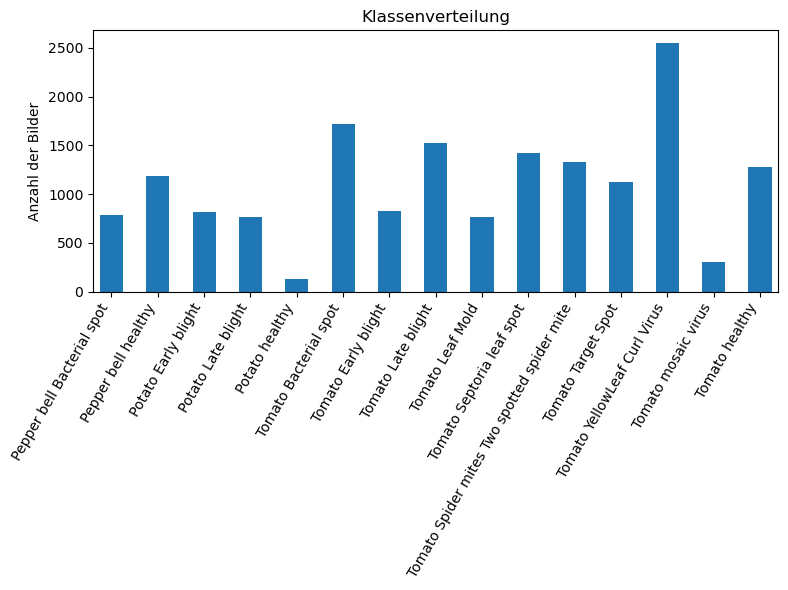

In [47]:
plt.figure(figsize=(8, 6))
bar_positions = np.arange(len(standardized_class_counts))  # Bar positions
bar_width = 0.5
plt.bar(bar_positions, list(standardized_class_counts.values()), width=bar_width)
plt.ylabel('Anzahl der Bilder')
plt.title('Klassenverteilung')
plt.xticks(bar_positions, list(standardized_class_counts.keys()), rotation=60, ha='right')
plt.gca().margins(x=0.01)
plt.tight_layout()
plt.show()

### Since the classes are imbalanced, accuracy is not the best KPI. The F1 score should be used.

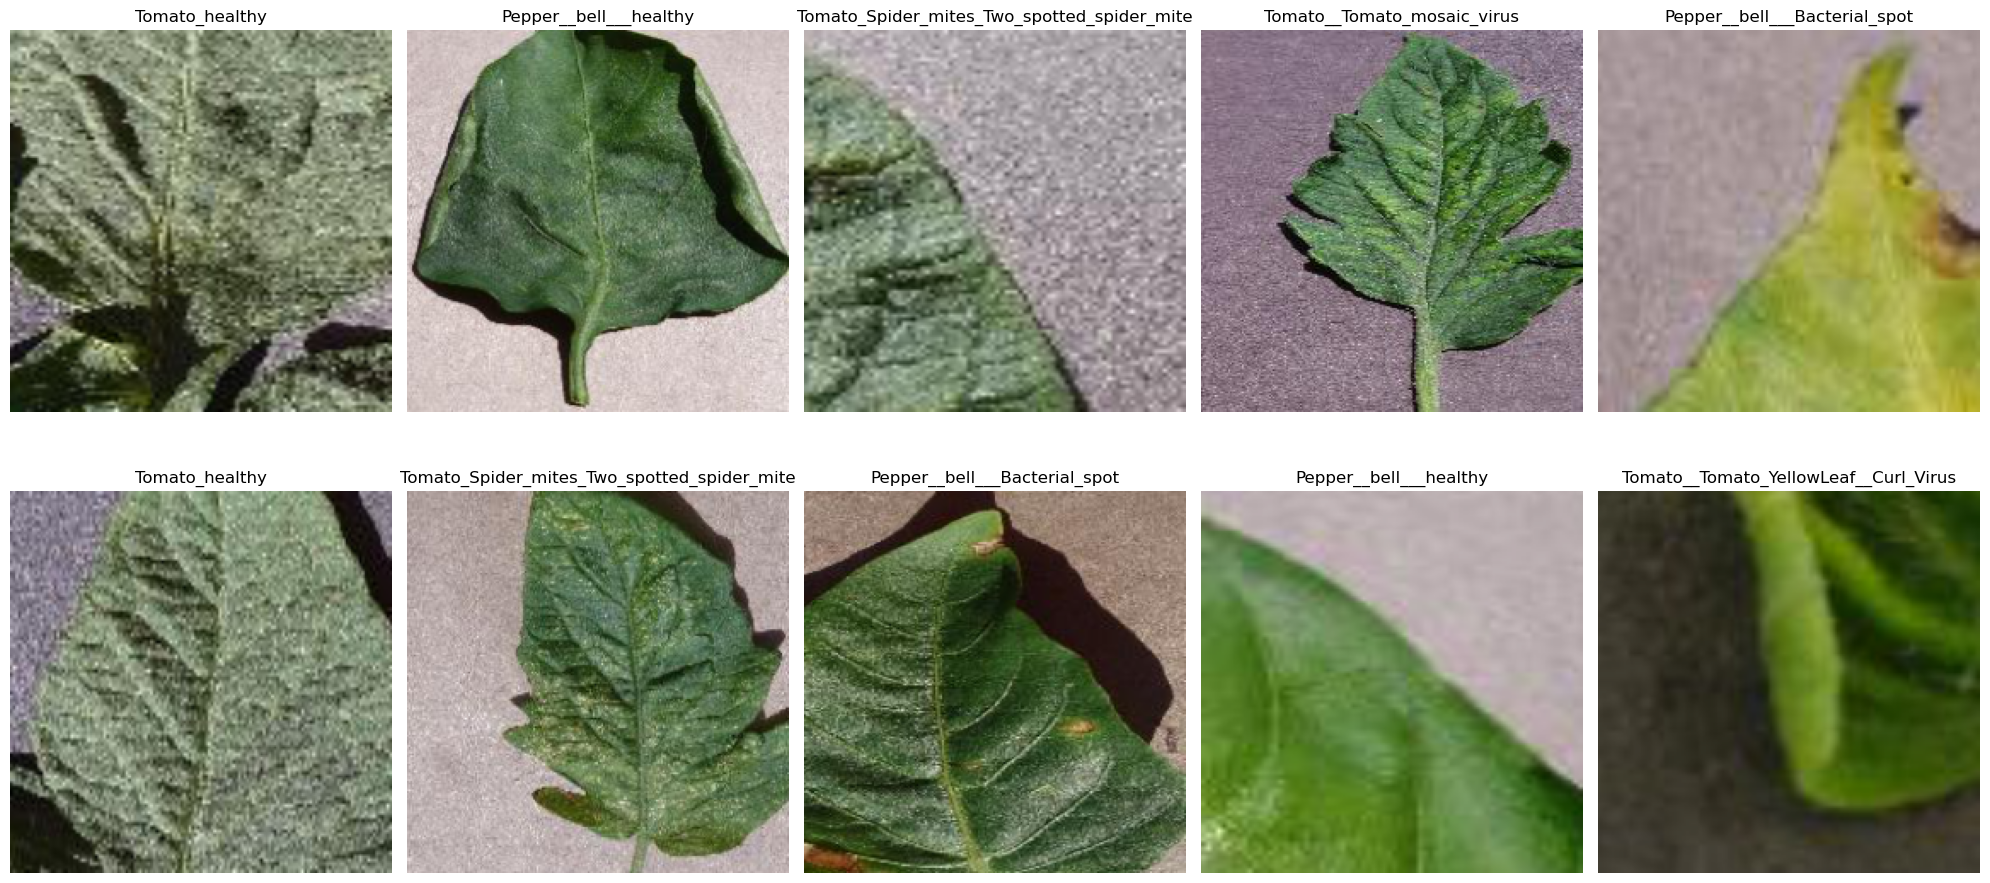

In [53]:
# 10 random images from the dataset
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# 10 random images and their labels
plt.figure(figsize=(20, 10))
for i in range(10):
    idx = random.randint(0, len(train_dataset) - 1)
    img, label = train_dataset[idx]
    plt.subplot(2, 5, i + 1)
    imshow(img, title=class_names[label])

plt.tight_layout()
plt.show()

# Parameter tuning with Cross Validation

The goal of the first part is to test various combinations of hyperparameters, such as learning rate and dropout, using Cross Validation to find the configuration that makes the model perform best. This process splits the data into parts and trains the model multiple times to choose the best possible parameters

In [25]:
from sklearn.model_selection import ParameterSampler

In [26]:
# Hyperparameter search space
param_grid = {
    'lr': [1e-4, 1e-3, 1e-2],
    'batch_size': [16, 32, 64],
    'dropout': [0.1, 0.25, 0.5],
    'optimizer': ['Adam', 'SGD'],
    'conv1_out_channels': [32, 64],
    'conv2_out_channels': [64, 128],
}

# Generate random parameter combinations
param_list = list(ParameterSampler(param_grid,
                                   n_iter=10,
                                   random_state=510))

In [27]:
# List to store parameters and their corresponding F1 scores
results = []

# Random search
best_params = None
best_f1 = 0.0

class TunableCNN(nn.Module):
    def __init__(self, num_classes, conv1_out_channels, conv2_out_channels, dropout_rate):
        super(TunableCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, conv1_out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(conv1_out_channels)
        self.conv2 = nn.Conv2d(conv1_out_channels, conv2_out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(conv2_out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(conv2_out_channels * 1 * 1, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
def train_and_evaluate(params):
    batch_size = params['batch_size']
    lr = params['lr']
    dropout_rate = params['dropout']
    optimizer_name = params['optimizer']
    conv1_out_channels = params['conv1_out_channels']
    conv2_out_channels = params['conv2_out_channels']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    model = TunableCNN(num_classes, conv1_out_channels, conv2_out_channels, dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr) if optimizer_name == 'Adam' else optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    num_epochs = 10
    best_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataset)

        # Evaluate on validation set
        model.eval()
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        val_f1 = f1_score(all_labels, all_predictions, average='weighted')
        if val_f1 > best_f1:
            best_f1 = val_f1

    return best_f1

for params in param_list:
    val_f1 = train_and_evaluate(params)
    results.append({**params, 'f1_score': val_f1})  # Save params and F1 score
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_params = params

# Convert results to a DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('hyperparameter_results.csv', index=False)

print(f'Best F1 Score: {best_f1}')
print(f'Best Params: {best_params}')

# Save the best model configuration
best_model = TunableCNN(num_classes, best_params['conv1_out_channels'], best_params['conv2_out_channels'], best_params['dropout']).to(device)
torch.save(best_model.state_dict(), 'best_tunable_cnn.pth')

Best F1 Score: 0.838311090450718
Best Params: {'optimizer': 'Adam', 'lr': 0.01, 'dropout': 0.5, 'conv2_out_channels': 128, 'conv1_out_channels': 64, 'batch_size': 64}


# Training and Validation loss / F1 score over 20 epochs

The goal of the second part is to train the model from scratch, now with the best-found parameters, using the entire dataset. This full training allows the model to learn as effectively as possible and achieve the best performance

In [30]:
# Visualizing the results

results_df = pd.read_csv('hyperparameter_results.csv')
results_df

optimizer      lr  dropout  conv2_out_channels  conv1_out_channels  \
0      Adam  0.0001     0.50                  64                  64   
1       SGD  0.0001     0.10                 128                  64   
2       SGD  0.0010     0.50                 128                  64   
3      Adam  0.0001     0.10                  64                  32   
4      Adam  0.0001     0.50                 128                  64   
5      Adam  0.0001     0.25                  64                  32   
6       SGD  0.0001     0.10                  64                  32   
7      Adam  0.0010     0.50                  64                  32   
8      Adam  0.0100     0.50                 128                  64   
9       SGD  0.0100     0.10                  64                  32   

   batch_size  f1_score  
0          64  0.640800  
1          64  0.175479  
2          64  0.316986  
3          32  0.668523  
4          32  0.687747  
5          16  0.681247  
6          64  0.107264  
7          32  0.804837  
8          64  0.838311  
9          64  0.602166

In [31]:
# Extract the best parameters and their corresponding metrics from the csv file
best_result = results_df.loc[results_df['f1_score'].idxmax()]
best_params = best_result.to_dict()
best_f1 = best_params['f1_score']

print(f'Best F1 Score: {best_f1}')
print(f'Best Params: {best_params}')

Best F1 Score: 0.838311090450718
Best Params: {'optimizer': 'Adam', 'lr': 0.01, 'dropout': 0.5, 'conv2_out_channels': 128, 'conv1_out_channels': 64, 'batch_size': 64, 'f1_score': 0.838311090450718}


In [34]:
print(f'Best Params: {best_params}')

best_model = TunableCNN(num_classes, best_params['conv1_out_channels'], best_params['conv2_out_channels'], best_params['dropout']).to(device)
best_model.load_state_dict(torch.load('best_tunable_cnn.pth', map_location=torch.device('cpu'), weights_only=True))

# optimizer and criterion
optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr']) if best_params['optimizer'] == 'Adam' else optim.SGD(best_model.parameters(), lr=best_params['lr'])
criterion = nn.CrossEntropyLoss()

print("Model and optimizer loaded successfully!")

Best Params: {'optimizer': 'Adam', 'lr': 0.01, 'dropout': 0.5, 'conv2_out_channels': 128, 'conv1_out_channels': 64, 'batch_size': 64, 'f1_score': 0.838311090450718}
Model and optimizer loaded successfully!


In [35]:
from tqdm import tqdm

In [36]:
num_epochs = 20
train_losses = []
val_losses = []
val_f1_scores = []
best_val_f1 = 0.0
best_model_wts = best_model.state_dict() 

for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0
    
    # Bar
    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Evaluate on validation set
    best_model.eval()
    all_labels = []
    all_predictions = []
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_val_loss = val_running_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)
    val_f1 = f1_score(all_labels, all_predictions, average='weighted')
    val_f1_scores.append(val_f1)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val F1 Score: {val_f1:.4f}')

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_wts = best_model.state_dict()  # Save best model weights


torch.save(best_model_wts, 'best_finetuned_tunable_cnn.pth')
print(f'Model saved with best validation F1 score: {best_val_f1:.4f}')


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:31<00:00,  1.41s/it]


Epoch 1/20, Train Loss: 1.6872, Val Loss: 1.2786, Val F1 Score: 0.5506


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:26<00:00,  1.33s/it]


Epoch 2/20, Train Loss: 1.3031, Val Loss: 0.9700, Val F1 Score: 0.6536


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:26<00:00,  1.33s/it]


Epoch 3/20, Train Loss: 1.1327, Val Loss: 0.9376, Val F1 Score: 0.6993


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:26<00:00,  1.34s/it]


Epoch 4/20, Train Loss: 1.0372, Val Loss: 0.9052, Val F1 Score: 0.6993


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:26<00:00,  1.32s/it]


Epoch 5/20, Train Loss: 0.9305, Val Loss: 0.7667, Val F1 Score: 0.7530


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:27<00:00,  1.34s/it]


Epoch 6/20, Train Loss: 0.8707, Val Loss: 0.6890, Val F1 Score: 0.7898


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:26<00:00,  1.33s/it]


Epoch 7/20, Train Loss: 0.8335, Val Loss: 0.6126, Val F1 Score: 0.7959


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:55<00:00,  1.77s/it]


Epoch 8/20, Train Loss: 0.7780, Val Loss: 0.5502, Val F1 Score: 0.8319


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:32<00:00,  1.42s/it]


Epoch 9/20, Train Loss: 0.7616, Val Loss: 0.5480, Val F1 Score: 0.8270


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:27<00:00,  1.35s/it]


Epoch 10/20, Train Loss: 0.7213, Val Loss: 0.5038, Val F1 Score: 0.8368


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:25<00:00,  1.31s/it]


Epoch 11/20, Train Loss: 0.6893, Val Loss: 0.5304, Val F1 Score: 0.8178


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:25<00:00,  1.31s/it]


Epoch 12/20, Train Loss: 0.6848, Val Loss: 0.4842, Val F1 Score: 0.8405


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:24<00:00,  1.31s/it]


Epoch 13/20, Train Loss: 0.6723, Val Loss: 0.4124, Val F1 Score: 0.8790


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:25<00:00,  1.31s/it]


Epoch 14/20, Train Loss: 0.6350, Val Loss: 0.4850, Val F1 Score: 0.8457


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:25<00:00,  1.32s/it]


Epoch 15/20, Train Loss: 0.6333, Val Loss: 0.4406, Val F1 Score: 0.8570


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:27<00:00,  1.35s/it]


Epoch 16/20, Train Loss: 0.6254, Val Loss: 0.3558, Val F1 Score: 0.8962


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:25<00:00,  1.32s/it]


Epoch 17/20, Train Loss: 0.6269, Val Loss: 0.4142, Val F1 Score: 0.8704


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:25<00:00,  1.32s/it]


Epoch 18/20, Train Loss: 0.6109, Val Loss: 0.4728, Val F1 Score: 0.8411


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:26<00:00,  1.33s/it]


Epoch 19/20, Train Loss: 0.6150, Val Loss: 0.3909, Val F1 Score: 0.8877


Validating: 100%|██████████████████████████████████████████████████████████████████████| 65/65 [01:25<00:00,  1.32s/it]

Epoch 20/20, Train Loss: 0.6012, Val Loss: 0.4613, Val F1 Score: 0.8548
Model saved with best validation F1 score: 0.8962


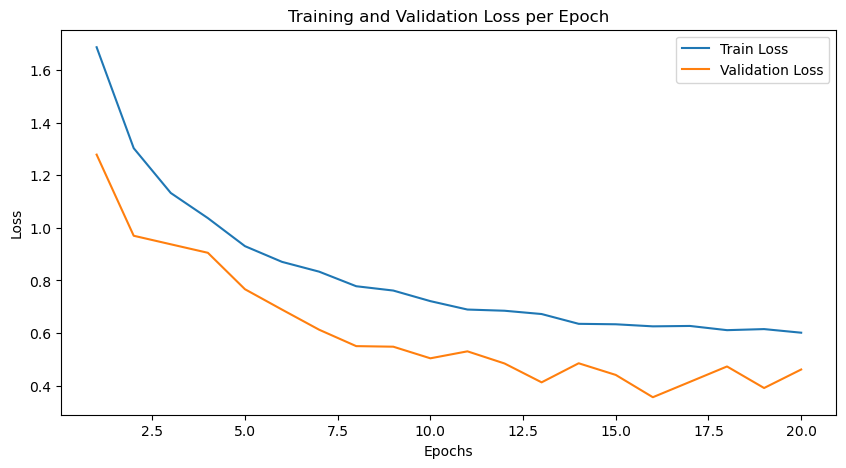

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

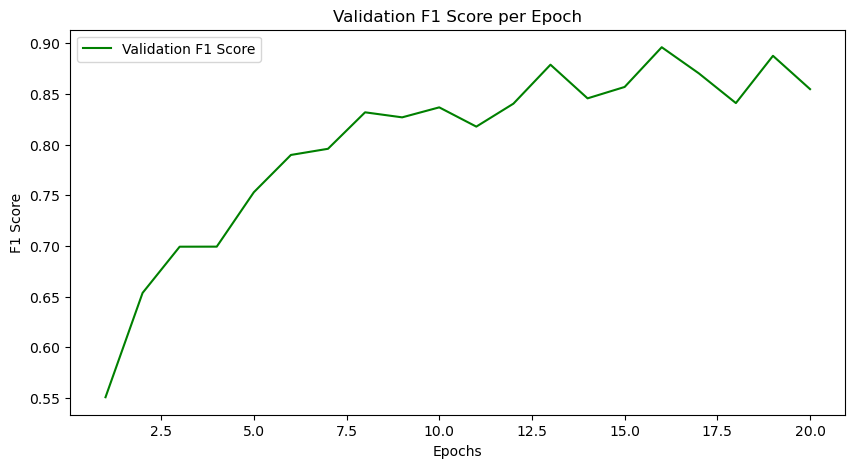

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), val_f1_scores, label='Validation F1 Score', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score per Epoch')
plt.legend()
plt.show()

# Grad Cam

The goal of GradCAM is to generate visualizations that show which parts of the image have the most influence on the model's decisions. This helps to understand how the model sees the image and which features it uses to make its classifications


You need to re-run all Data Preprocessing section, cnn definition, cell with results_df and cell with "Extract best parameters", case you already trained the model and want to run just the GradCam

In [67]:
# Load the best finetuned model
best_model = TunableCNN(num_classes, best_params['conv1_out_channels'], best_params['conv2_out_channels'], best_params['dropout']).to(device)
best_model.load_state_dict(torch.load('best_finetuned_tunable_cnn.pth', map_location=device))

# Define optimizer and criterion
optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr']) if best_params['optimizer'] == 'Adam' else optim.SGD(best_model.parameters(), lr=best_params['lr'])
criterion = nn.CrossEntropyLoss()

In [68]:
print("Model architecture and output shapes:")
input_image = torch.randn(1, 3, 224, 224).to(device)  
x = input_image

for name, module in best_model.named_modules():
    try:
        x = module(x)
        if len(x.shape) == 4:  #
            print(f"{name}: {x.shape}")
        else:
            break  
    except Exception as e:
        print(f"Error in {name}: {e}")
        break


Model architecture and output shapes:


In [73]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass(self, x):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_out[0]
            print("Gradients saved with shape:", self.gradients.shape)

        target_layer_module = dict([*self.model.named_modules()])[self.target_layer]
        target_layer_module.register_full_backward_hook(hook_function)

        self.activations = None
        self.gradients = None

        for name, module in self.model.named_children():
            x = module(x)
            if name == self.target_layer:
                self.activations = x
                break
        return self.activations, x

    def generate_cam(self, input_image, target_class=None):
        conv_output, _ = self.forward_pass(input_image)

        # Perform a full forward pass to get the class scores
        model_output = self.model(input_image)

        if target_class is None:
            target_class = torch.argmax(model_output, dim=1).item()

        self.model.zero_grad()

        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0, target_class] = 1

        # Perform backward pass
        model_output.backward(gradient=one_hot_output, retain_graph=True)

        # Create CAM
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = conv_output.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
        cam -= np.min(cam)
        cam /= np.max(cam)

        return cam

In [74]:
def apply_heatmap(cam, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), colormap)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap * alpha + np.float32(image) * (1 - alpha)
    overlay = overlay / np.max(overlay)
    return np.uint8(255 * overlay)


In [79]:
images = []
cam_images = []

# Generate GradCAM for 5 random images from the validation dataset
for i in range(5):
    idx = random.randint(0, len(val_dataset) - 1)
    img, label = val_dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)

    print(f'Image tensor shape: {img_tensor.shape}')

    cam = gradcam.generate_cam(img_tensor)

    if cam is None:
        print("GradCAM failed to generate CAM for this image")
        continue

    # Apply Gaussian smoothing to the CAM
    cam = cv2.GaussianBlur(cam, (5, 5), 0)

    # Convert the image to the same format as the heatmap
    image = img.permute(1, 2, 0).cpu().numpy()
    image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Normalize image
    cam_image = apply_heatmap(cam, image)

    # Store the images for plotting
    images.append((image, class_names[label]))
    cam_images.append(cam_image)


Image tensor shape: torch.Size([1, 3, 224, 224])
Hook registered on layer: conv2
Performing backward pass
Gradients saved with shape: torch.Size([1, 128, 112, 112])
Gradients saved with shape: torch.Size([1, 128, 112, 112])
Gradients saved with shape: torch.Size([1, 128, 112, 112])
Gradients saved with shape: torch.Size([1, 128, 112, 112])
Gradients saved with shape: torch.Size([1, 128, 112, 112])
Gradients saved with shape: torch.Size([1, 128, 112, 112])
Gradients saved with shape: torch.Size([1, 128, 112, 112])
Gradients saved with shape: torch.Size([1, 128, 112, 112])
Gradients saved with shape: torch.Size([1, 128, 112, 112])
Gradients saved with shape: torch.Size([1, 128, 112, 112])
Gradients saved with shape: torch.Size([1, 128, 112, 112])
Backward pass completed
Gradients shape: torch.Size([1, 128, 112, 112])
Gradients: tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,

C:\Users\patri\AppData\Local\Temp\ipykernel_16148\1832868557.py:75: RuntimeWarning: invalid value encountered in divide
  cam /= np.max(cam)
C:\Users\patri\AppData\Local\Temp\ipykernel_16148\3363223780.py:2: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), colormap)


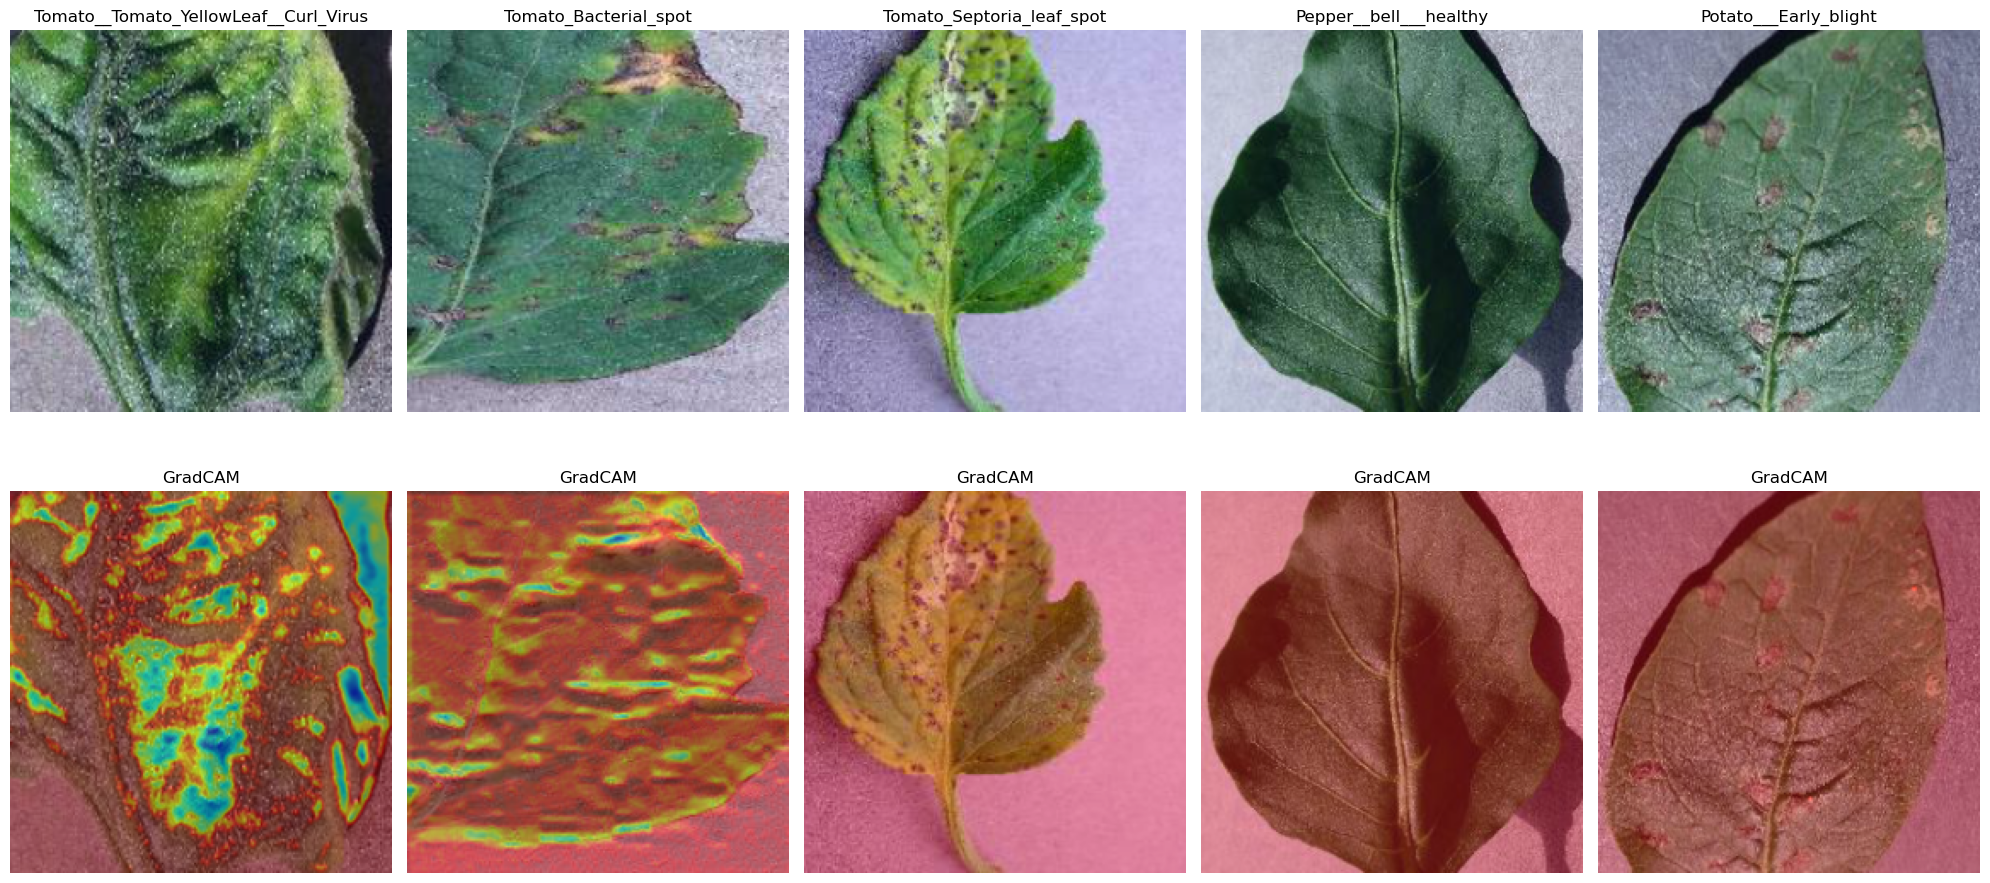

In [80]:

plt.figure(figsize=(20, 10))
for i in range(5):
    # Plot the original image
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i][0])
    plt.title(images[i][1])
    plt.axis('off')

    # Plot the GradCAM heatmap overlay
    plt.subplot(2, 5, i + 6)
    plt.imshow(cam_images[i])
    plt.title('GradCAM')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Random Test

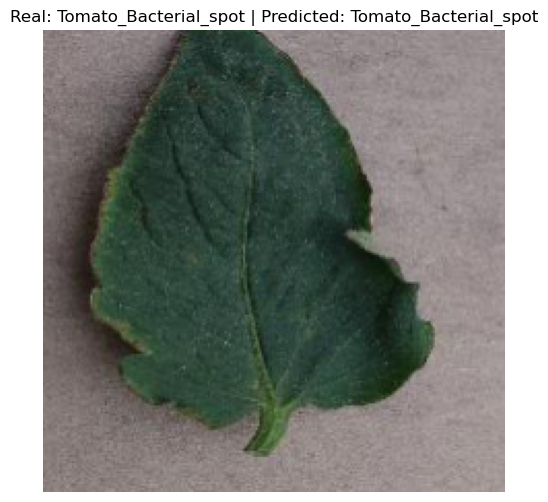

In [88]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Load the fine-tuned model
best_model = TunableCNN(
    num_classes=num_classes, 
    conv1_out_channels=best_params['conv1_out_channels'],
    conv2_out_channels=best_params['conv2_out_channels'],
    dropout_rate=best_params['dropout']
).to(device)

best_model.load_state_dict(torch.load('best_finetuned_tunable_cnn.pth', map_location=device)) # Weights from fine Tuning
best_model.eval()

# Randomly select an image
random_idx = random.randint(0, len(test_dataset) - 1)
test_img, test_label = test_dataset[random_idx]

input_img = test_img.unsqueeze(0).to(device) 

with torch.no_grad():
    outputs = best_model(input_img)
    _, predicted_label = torch.max(outputs, 1)

# real and predicted class names
real_class = class_names[test_label]
predicted_class = class_names[predicted_label.item()]

plt.figure(figsize=(6, 6))
imshow(test_img, title=f"Real: {real_class} | Predicted: {predicted_class}")
plt.show()
